In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
from simulation_utils import mix_data_splits, run_std_approach
from DataGenerator import DataGenerator
from constants import RANDOM_SEED, PARAMS

In [2]:
dg = DataGenerator(random_seed=RANDOM_SEED)
X_train, y_train, X_test, y_test, y_test_no_coi, res_proportion, coefs, res_coefs = dg.generate_linear_data(**PARAMS)

fig_name = f'stdapp_lin_datasplits_{PARAMS["effective_rank"]}rank_{PARAMS["n_common"]}common_{PARAMS["noise"]}noise_{PARAMS["n_informative"]}_\
informative_res_coef{PARAMS["res_coef_value"]}_gt_coef{PARAMS["gt_coef_value"]}'
fig_save_path = f'../../../sent/simulated/leave_out/figure/{fig_name}.png'

In [3]:
# Combine data to get training dataset
X = pd.concat([X_train, X_test])
# assemble y without any COI effects. Will be successively added in below.
y = pd.concat([y_train, y_test_no_coi])

#### Select predictors (i.e., model knowledge)

In [4]:
# the empty series will yield an empty index which is needed in the loops below
splits_res = [pd.Series([])] + np.array_split(res_coefs[-PARAMS["n_informative"]:], 3)
simulation_dfs = []
cols = []
res_proportions = []

space = np.linspace(0.00, 1., 4)
space[0] = 0.1
for i in range(len(splits_res)):
    cols.append(splits_res[i].index)
    cols_drop = [str(x) for x in np.concatenate([x.values for x in cols])]
    for j in space:
        y_train_new, test_ids, resprop = mix_data_splits(X, y, res_coefs, 
                                                         fraction=j, 
                                                random_seed=RANDOM_SEED, 
                                                pass_ids=True, pass_res_prop=True)

        # split data and labels again to get results for current iteration
        X_train_reduced = X.drop(index=test_ids, columns=cols_drop, errors='ignore')
        y_train_reduced = y_train_new.drop(index=test_ids)
        X_test_reduced = X.drop(columns=cols_drop, errors='ignore').loc[test_ids]
        y_test_reduced = y_train_new.loc[test_ids]

        res_proportions.append(resprop)
        simulation_dfs.append(
            run_std_approach(X_train_reduced, y_train_reduced, 
                             X_test_reduced, y_test_reduced, combine=True)
        )

/Users/cbirkenbihl/git/Cog_resilience/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [5]:
pickle.dump(simulation_dfs, open(f'../../../sent/simulated/leave_out/pickles/{fig_name}.p', 'wb'))

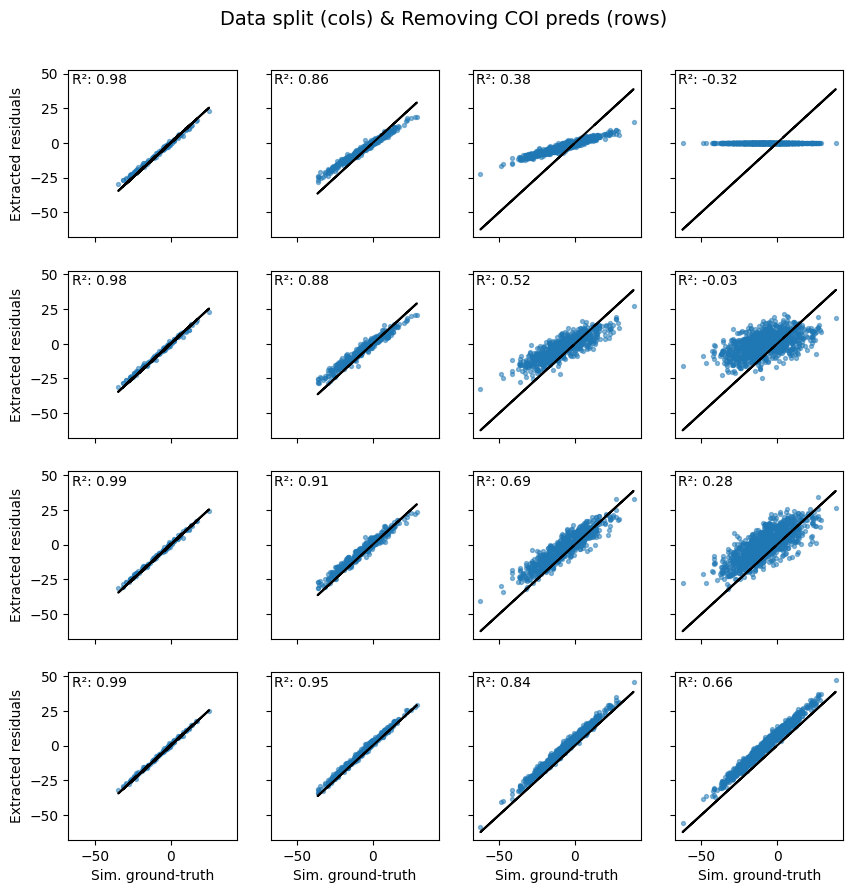

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
plt.suptitle("Data split (cols) & Removing COI preds (rows)", fontsize=14, y=0.94)

for (results_std_app, r2gt), res_proportion, ax in zip(simulation_dfs, res_proportions, axes.flatten()):
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"R²: {r2_score(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)

for ax in axes[:, 0]:
    ax.set_ylabel("Extracted residuals")
for ax in axes[-1]:
    ax.set_xlabel("Sim. ground-truth")
plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')

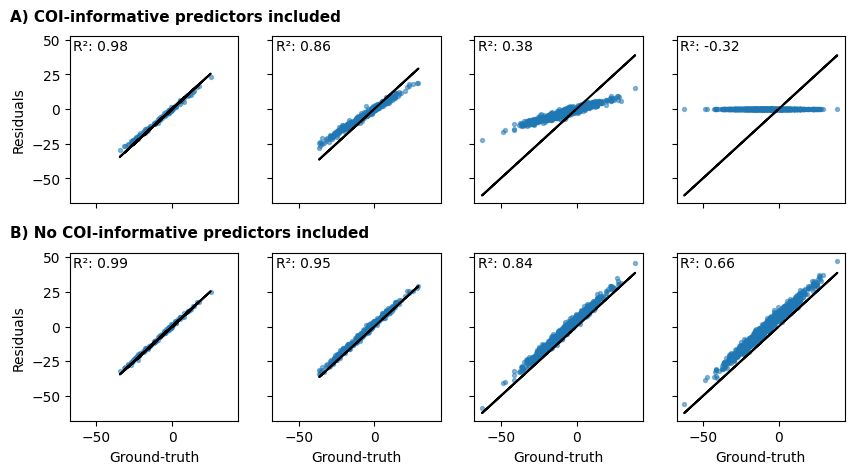

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
# plt.suptitle("Simulation results for linear assumption on gt and resilience", fontsize=14, y=0.94)

for i, ax in enumerate(axes.flatten()[:4]):
    res_proportion = res_proportions[i]
    results_std_app = simulation_dfs[i][0]
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"R²: {r2_score(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)

    
for (results_std_app, r2gt), res_proportion, ax in zip(simulation_dfs[-4::], 
                                                       res_proportions[-4::], 
                                                       axes.flatten()[4:]):
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"R²: {r2_score(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)

plt.figtext(0.065, 0.933, "A) COI-informative predictors included", ha="left", va="top", weight='bold', fontsize=11)
plt.figtext(0.065, 0.5, "B) No COI-informative predictors included", ha="left", va="top", weight='bold', fontsize=11)
plt.subplots_adjust(hspace = 0.3)

for ax in axes[:, 0]:
    ax.set_ylabel("Residuals", fontsize=10)
for ax in axes[-1]:
    ax.set_xlabel("Ground-truth", fontsize=10)
plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')